## LSTM for time-series forecasting on water flow data gathered by the Karachi Water Project

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scienceplots
import os

plt.style.use(['science','ieee'])

c:\Users\akeel\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def read_data(n):
  url = "data_v9_flow_cleaned.csv"
  if n != None:
    df_raw = pd.read_csv(url, nrows=n)
  else:
    df_raw = pd.read_csv(url)
  return df_raw

# 5 Minute Volume

In [3]:
def five_min_window(df_raw, scaler):
  df = df_raw.groupby(df_raw['5min_count']).sum().reset_index()
  df = df.loc[:,["volume"]]
  df = scaler.fit_transform(df)
  df = tf.convert_to_tensor(df)

  print("1. Data has been read")
  print("2. Data being sliced into windows")

  window_len = 12
  stride = 2

  assert len(df) > window_len + 1

  new = []
  for i in range(window_len, len(df), stride):
    if i % 10000 == 0:
      print(i, "/", len(df))
    new.append([df[i-window_len:i], df[i]])

  df = new

  train_ratio = 0.8
  sequence_len = len(df)

  train_data = df[0:int(sequence_len*train_ratio)]
  test_data = df[int(sequence_len*train_ratio):]

  print("3. Completed")

  return train_data, test_data, scaler

In [4]:
df_raw = read_data(n=None)

In [5]:
scaler = StandardScaler() 
train_data, test_data, scaler = five_min_window(df_raw, scaler)

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


# Loop over all training examples 
for datax, datay in zip(train_data, test_data):
  training_sentences.append(np.array(datax[0]))
  training_labels.append(datax[1])
  testing_sentences.append(np.array(datay[0]))
  testing_labels.append(datay[1])

# Convert labels lists to numpy array
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)
testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

1. Data has been read
2. Data being sliced into windows
3. Completed


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [ ]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, input_shape=(training_sentences.shape[1], training_sentences.shape[2]), activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(40, activation='linear'),
    tf.keras.layers.Dense(30, activation='linear'),
    tf.keras.layers.Dense(20, activation='linear'),
    tf.keras.layers.Dense(10, activation='linear'),
    tf.keras.layers.Dense(1, activation='linear')
])

Epoch 1/100
26/26 [==============================] - 30s 249ms/step - loss: 0.9232 - mean_squared_error: 0.9232 - val_loss: 1.7149 - val_mean_squared_error: 1.7149
Epoch 2/100
26/26 [==============================] - 2s 78ms/step - loss: 0.8316 - mean_squared_error: 0.8316 - val_loss: 1.6918 - val_mean_squared_error: 1.6918
Epoch 3/100
26/26 [==============================] - 2s 77ms/step - loss: 0.8056 - mean_squared_error: 0.8056 - val_loss: 1.6709 - val_mean_squared_error: 1.6709
Epoch 4/100
26/26 [==============================] - 2s 77ms/step - loss: 0.8110 - mean_squared_error: 0.8110 - val_loss: 1.6868 - val_mean_squared_error: 1.6868
Epoch 5/100
26/26 [==============================] - 2s 76ms/step - loss: 0.7961 - mean_squared_error: 0.7961 - val_loss: 1.7005 - val_mean_squared_error: 1.7005
Epoch 6/100
26/26 [==============================] - 2s 77ms/step - loss: 0.7962 - mean_squared_error: 0.7962 - val_loss: 1.5955 - val_mean_squared_error: 1.5955
Epoch 7/100
26/26 [=======

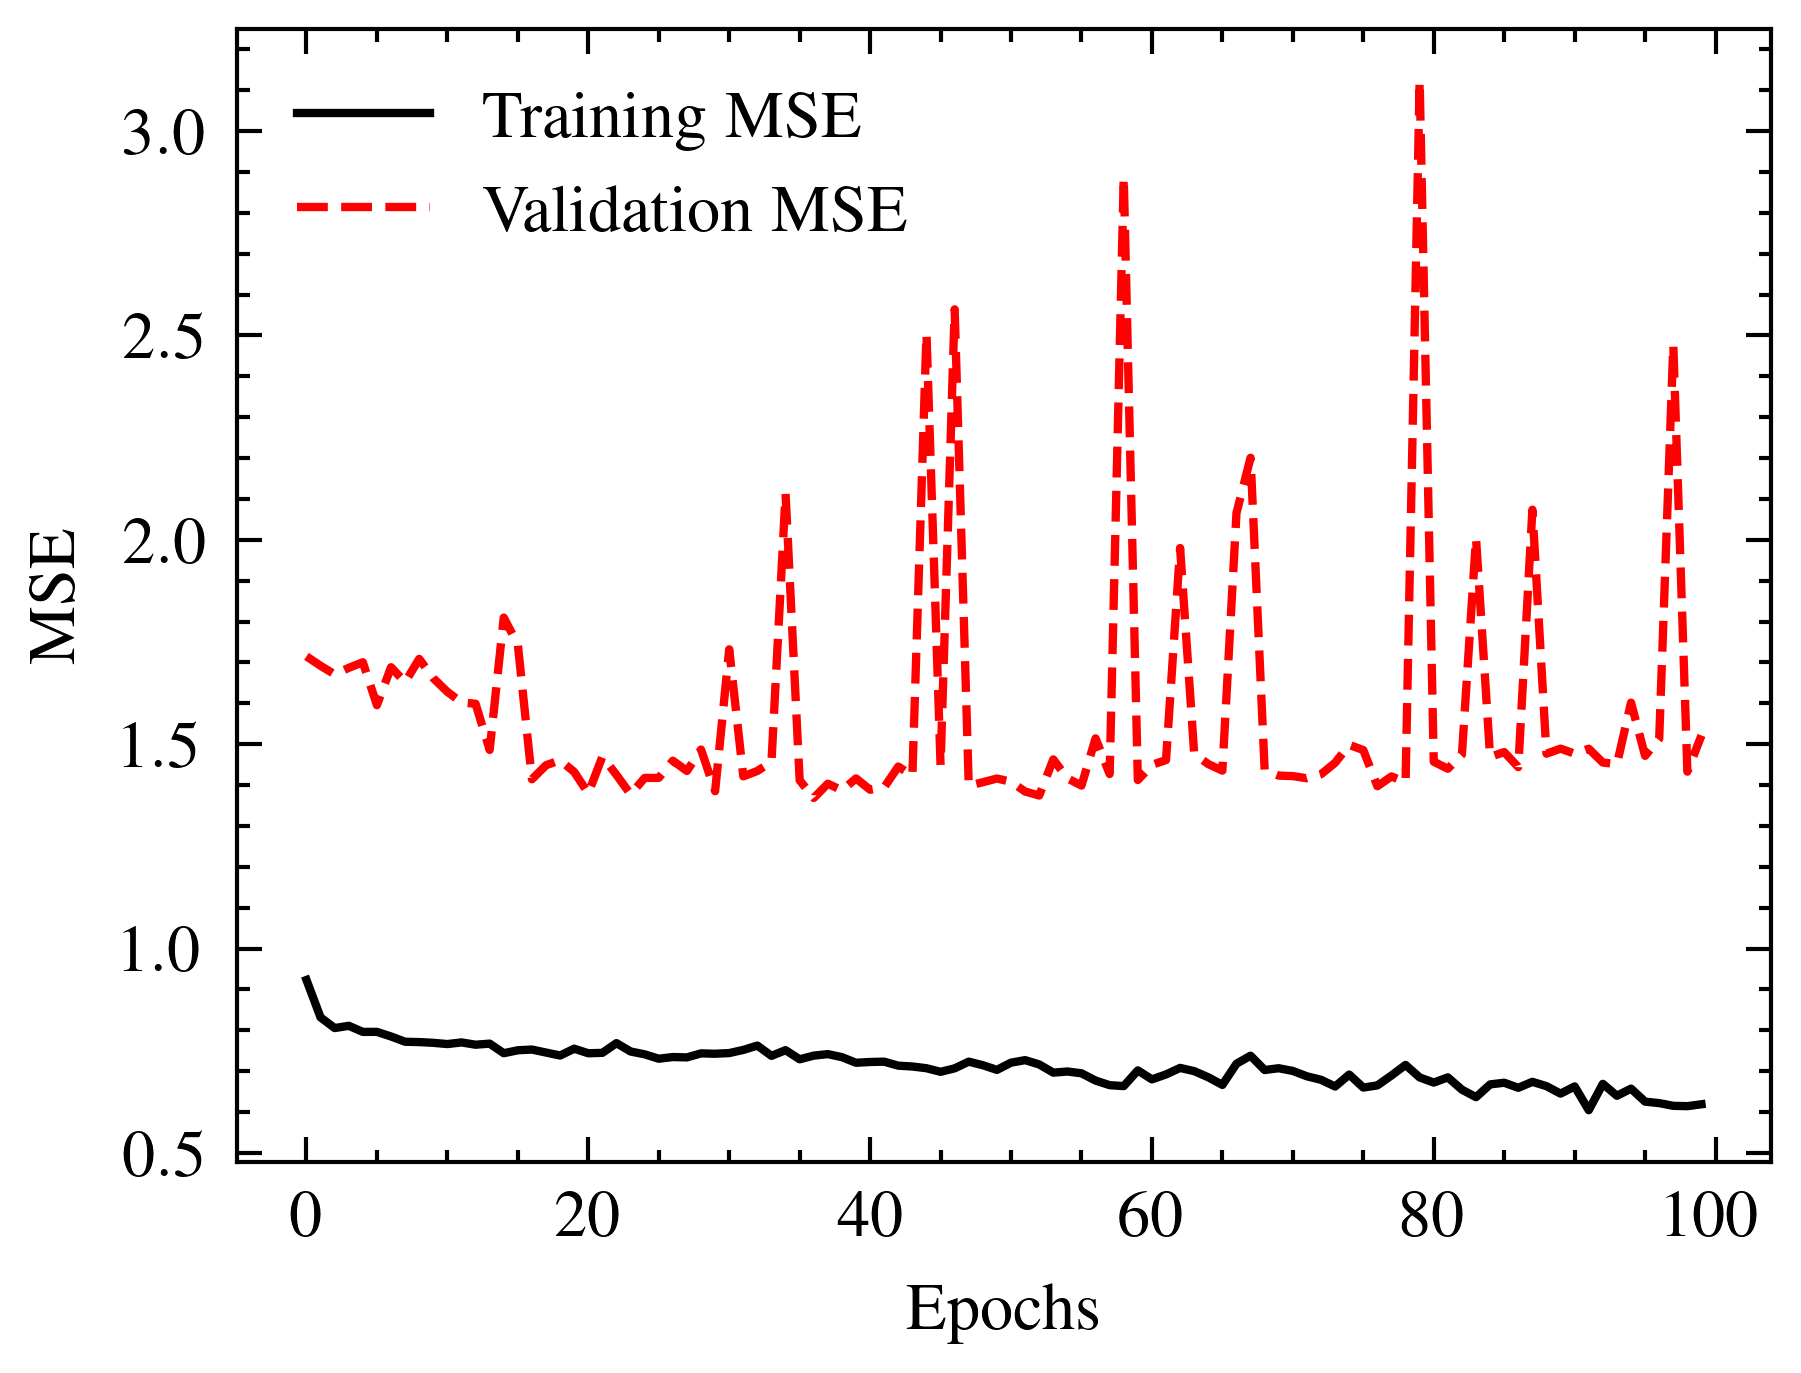

In [ ]:
# Set the training parameters
model_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mean_squared_error']) 

NUM_EPOCHS = 100
BATCH_SIZE = 256

# Train the model
history_lstm = model_lstm.fit(x=training_sentences, y=training_labels, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=(testing_sentences, testing_labels), 
                                    batch_size=BATCH_SIZE)
# Print the model summary
model_lstm.summary()

plt.plot(history_lstm.history['mean_squared_error'])
plt.plot(history_lstm.history['val_'+'mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel('MSE')
plt.legend(['Training MSE', 'Validation MSE'])
plt.show()

205/205 [==============================] - 8s 19ms/step


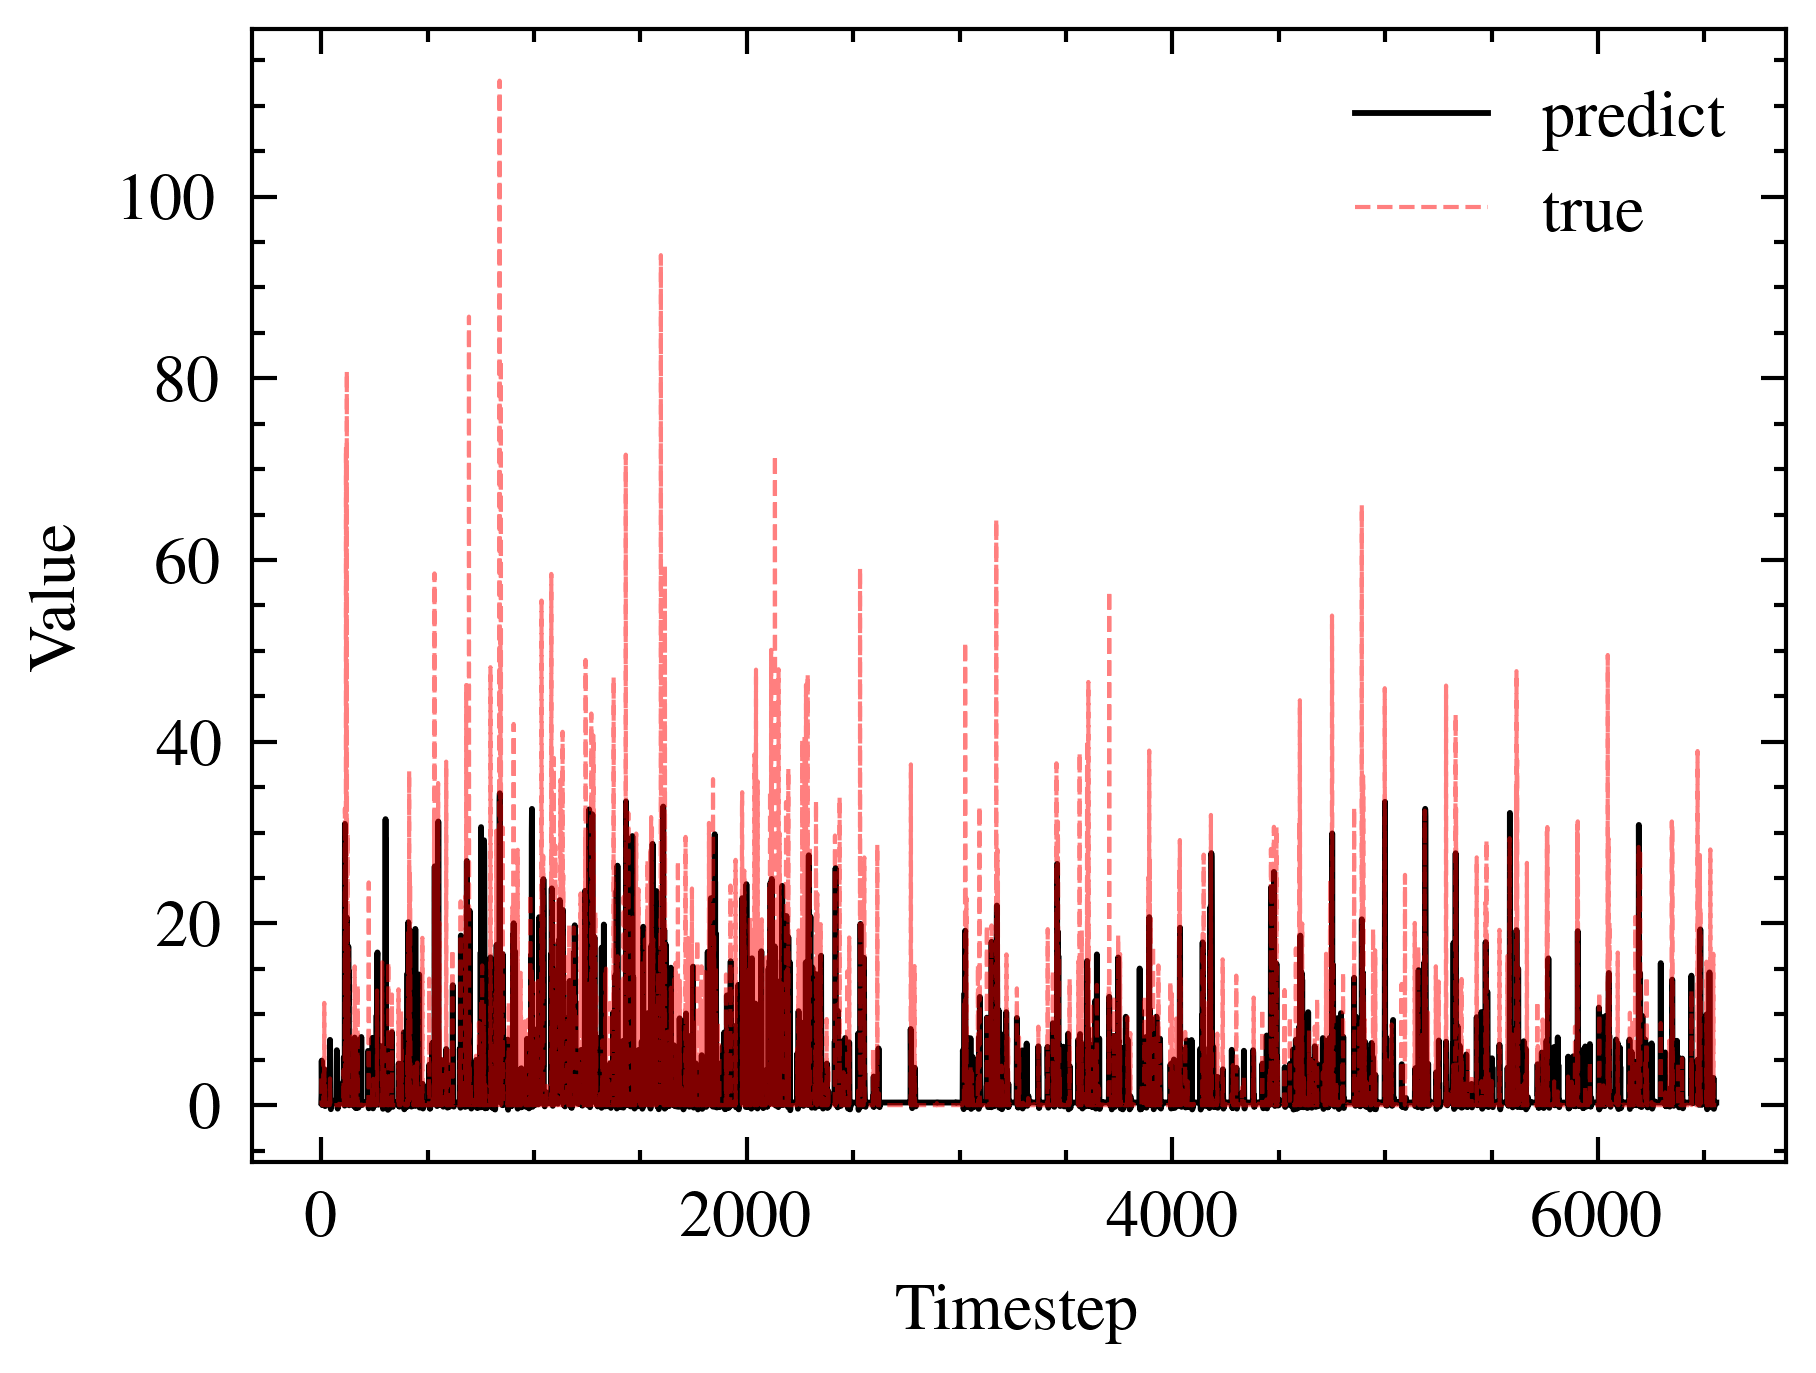

In [ ]:
predict = model_lstm.predict(testing_sentences)
predict = scaler.inverse_transform(predict)
plt.plot(predict, label="predict", linewidth=0.7, alpha=1.0)
testing_labels = scaler.inverse_transform(testing_labels)
plt.plot([i for i in range(testing_labels.shape[0])], testing_labels, linewidth=0.5, label="true", alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

# 30 Minute Volume

In [ ]:
def thirty_min_window(df_raw, scaler):
  df = df_raw.groupby(df_raw['30min_count']).sum().reset_index()
  df = df.loc[:,["volume"]]
  df = scaler.fit_transform(df)
  df = tf.convert_to_tensor(df)

  print("1. Data has been read")
  print("2. Data being sliced into windows")

  window_len = 24
  stride = 6

  assert len(df) > window_len + 1

  new = []
  for i in range(window_len, len(df), stride):
    if i % 10000 == 0:
      print(i, "/", len(df))
    new.append([df[i-window_len:i], df[i]])

  df = new

  train_ratio = 0.8
  sequence_len = len(df)

  train_data = df[0:int(sequence_len*train_ratio)]
  test_data = df[int(sequence_len*train_ratio):]

  print("3. Completed")

  return train_data, test_data, scaler

In [ ]:
df_raw = read_data(n=None)

In [ ]:
scaler = StandardScaler() 
train_data, test_data, scaler = thirty_min_window(df_raw, scaler)

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


# Loop over all training examples 
for datax, datay in zip(train_data, test_data):
  training_sentences.append(np.array(datax[0]))
  training_labels.append(datax[1])
  testing_sentences.append(np.array(datay[0]))
  testing_labels.append(datay[1])

# Convert labels lists to numpy array
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)
testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

1. Data has been read
2. Data being sliced into windows
3. Completed


In [ ]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, input_shape=(training_sentences.shape[1], training_sentences.shape[2]), activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(40, activation='linear'),
    tf.keras.layers.Dense(30, activation='linear'),
    tf.keras.layers.Dense(20, activation='linear'),
    tf.keras.layers.Dense(10, activation='linear'),
    tf.keras.layers.Dense(1, activation='linear')
])

Epoch 1/100
19/19 [==============================] - 28s 346ms/step - loss: 0.9444 - mean_squared_error: 0.9444 - val_loss: 1.7496 - val_mean_squared_error: 1.7496
Epoch 2/100
19/19 [==============================] - 1s 80ms/step - loss: 0.7783 - mean_squared_error: 0.7783 - val_loss: 1.7035 - val_mean_squared_error: 1.7035
Epoch 3/100
19/19 [==============================] - 1s 79ms/step - loss: 0.7590 - mean_squared_error: 0.7590 - val_loss: 1.6487 - val_mean_squared_error: 1.6487
Epoch 4/100
19/19 [==============================] - 1s 79ms/step - loss: 0.6765 - mean_squared_error: 0.6765 - val_loss: 1.6563 - val_mean_squared_error: 1.6563
Epoch 5/100
19/19 [==============================] - 1s 80ms/step - loss: 0.7142 - mean_squared_error: 0.7142 - val_loss: 1.7079 - val_mean_squared_error: 1.7079
Epoch 6/100
19/19 [==============================] - 1s 80ms/step - loss: 0.6402 - mean_squared_error: 0.6402 - val_loss: 1.5916 - val_mean_squared_error: 1.5916
Epoch 7/100
19/19 [=======

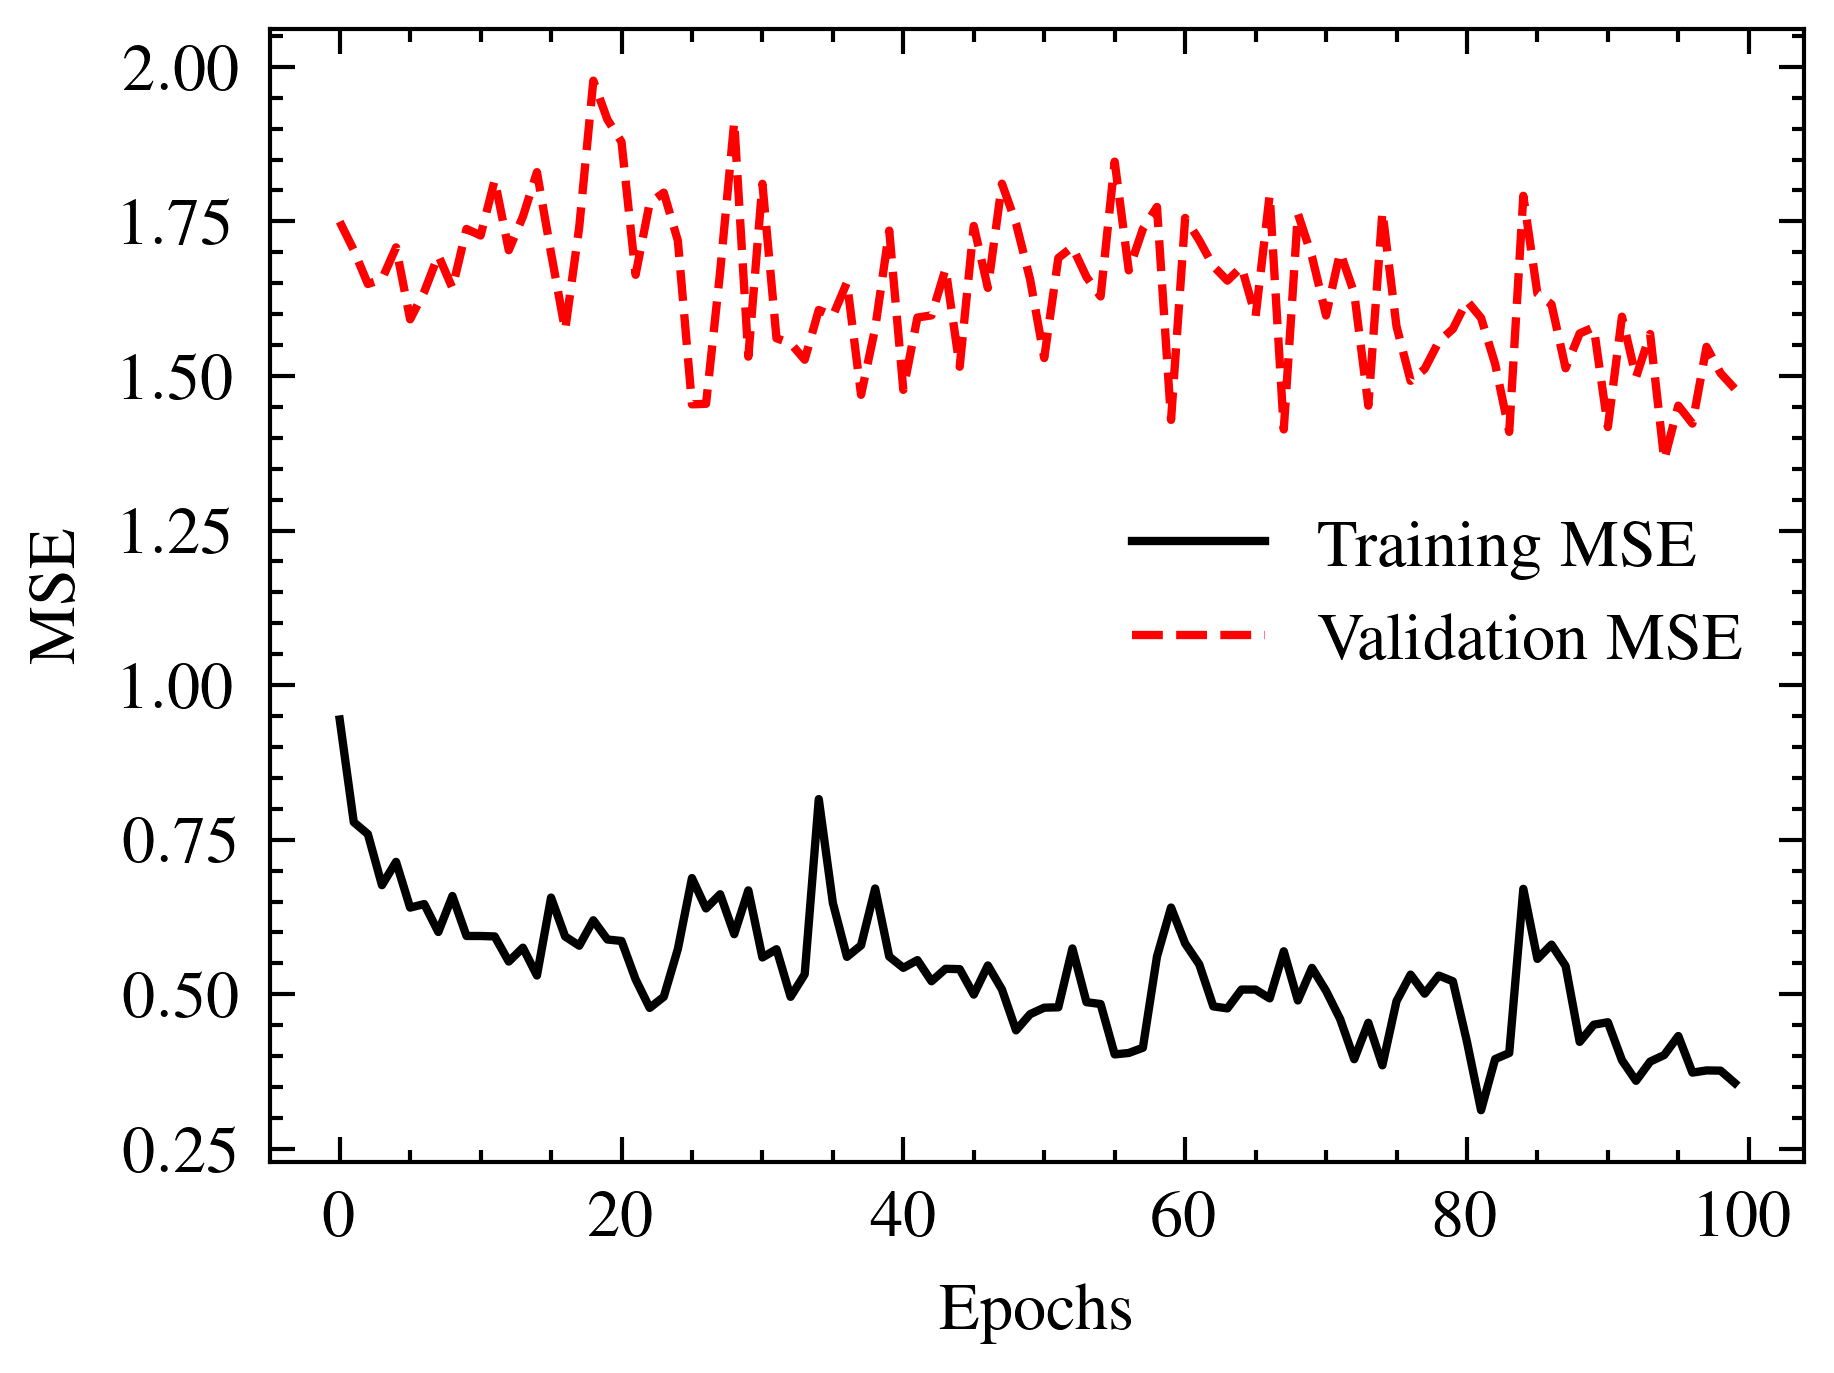

In [ ]:
# Set the training parameters
model_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mean_squared_error']) 


NUM_EPOCHS = 100
BATCH_SIZE = 20

# Train the model
history_lstm = model_lstm.fit(x=training_sentences, y=training_labels, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=(testing_sentences, testing_labels), 
                                    batch_size=BATCH_SIZE)
# Print the model summary
model_lstm.summary()

plt.plot(history_lstm.history['mean_squared_error'])
plt.plot(history_lstm.history['val_'+'mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel('MSE')
plt.legend(['Training MSE', 'Validation MSE'])
plt.show()

12/12 [==============================] - 4s 31ms/step


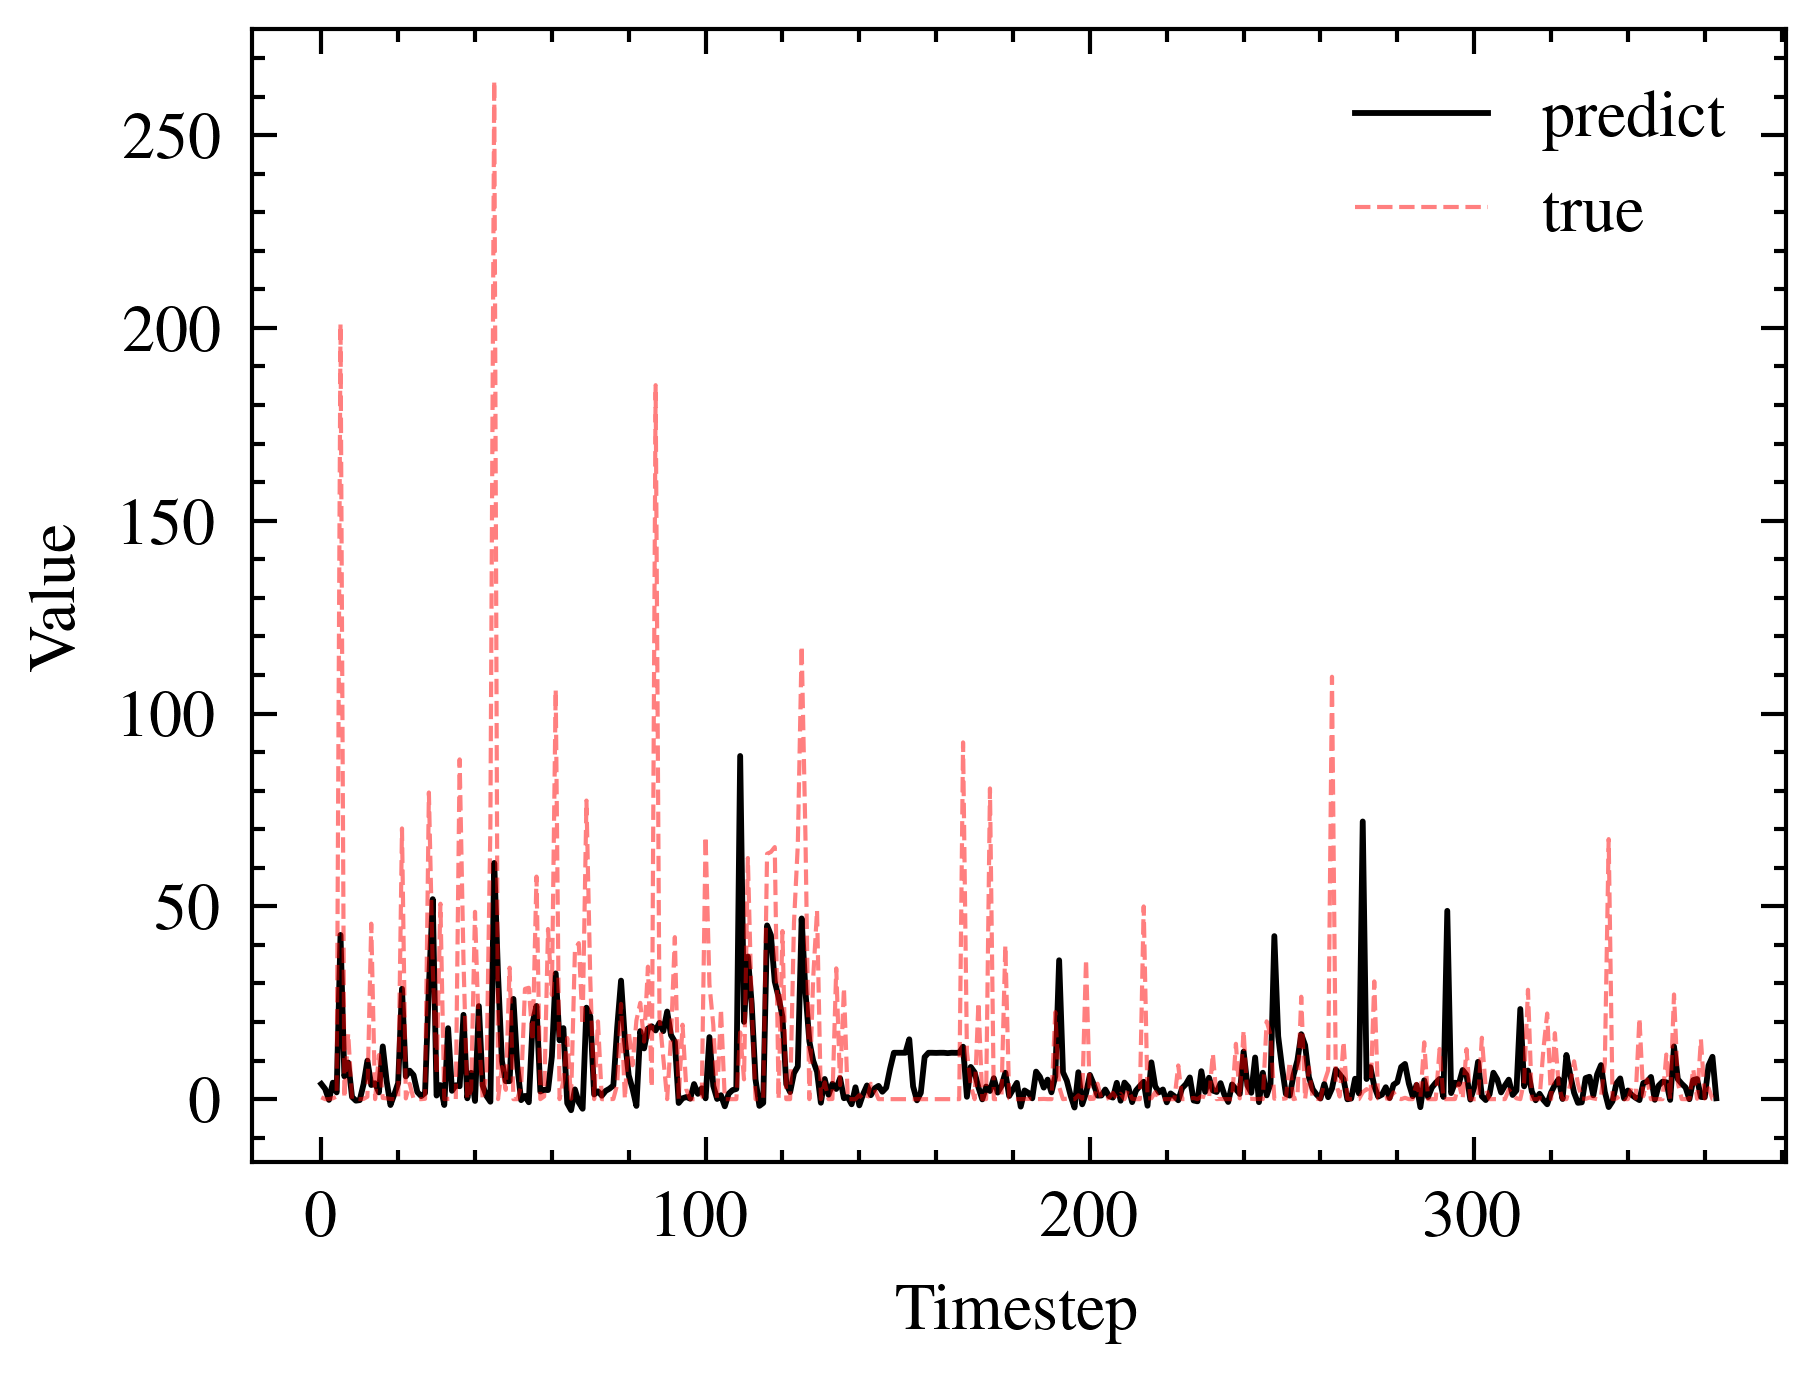

In [ ]:
predict = model_lstm.predict(testing_sentences)
predict = scaler.inverse_transform(predict)
plt.plot(predict, label="predict", linewidth=0.7, alpha=1.0)
testing_labels = scaler.inverse_transform(testing_labels)
plt.plot([i for i in range(testing_labels.shape[0])], testing_labels, linewidth=0.5, label="true", alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

# One Hour Volume

In [ ]:
def one_hour_window(df_raw, scaler):
  df = df_raw.groupby(df_raw['hour_count']).sum().reset_index()
  df = df.loc[:,["volume"]]
  df = scaler.fit_transform(df)
  df = tf.convert_to_tensor(df)

  print("1. Data has been read")
  print("2. Data being sliced into windows")

  window_len = 24
  stride = 6

  assert len(df) > window_len + 1

  new = []
  for i in range(window_len, len(df), stride):
    if i % 10000 == 0:
      print(i, "/", len(df))
    new.append([df[i-window_len:i], df[i]])

  df = new

  train_ratio = 0.8
  sequence_len = len(df)

  train_data = df[0:int(sequence_len*train_ratio)]
  test_data = df[int(sequence_len*train_ratio):]

  print("3. Completed")

  return train_data, test_data, scaler

In [ ]:
df_raw = read_data(n=None)

In [ ]:
scaler = StandardScaler() 
train_data, test_data, scaler = one_hour_window(df_raw, scaler)

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


# Loop over all training examples 
for datax, datay in zip(train_data, test_data):
  training_sentences.append(np.array(datax[0]))
  training_labels.append(datax[1])
  testing_sentences.append(np.array(datay[0]))
  testing_labels.append(datay[1])

# Convert labels lists to numpy array
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)
testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

1. Data has been read
2. Data being sliced into windows
3. Completed


In [ ]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, input_shape=(training_sentences.shape[1], training_sentences.shape[2]), activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(40, activation='linear'),
    tf.keras.layers.Dense(30, activation='linear'),
    tf.keras.layers.Dense(20, activation='linear'),
    tf.keras.layers.Dense(10, activation='linear'),
    tf.keras.layers.Dense(1, activation='linear')
])

Epoch 1/100
37/37 [==============================] - 27s 198ms/step - loss: 1.9185 - mean_squared_error: 1.9185 - val_loss: 3.3504 - val_mean_squared_error: 3.3504
Epoch 2/100
37/37 [==============================] - 3s 75ms/step - loss: 1.6265 - mean_squared_error: 1.6265 - val_loss: 3.3068 - val_mean_squared_error: 3.3068
Epoch 3/100
37/37 [==============================] - 3s 73ms/step - loss: 1.4131 - mean_squared_error: 1.4131 - val_loss: 3.0702 - val_mean_squared_error: 3.0702
Epoch 4/100
37/37 [==============================] - 3s 74ms/step - loss: 1.4224 - mean_squared_error: 1.4224 - val_loss: 3.0403 - val_mean_squared_error: 3.0403
Epoch 5/100
37/37 [==============================] - 3s 74ms/step - loss: 1.3667 - mean_squared_error: 1.3667 - val_loss: 3.0916 - val_mean_squared_error: 3.0916
Epoch 6/100
37/37 [==============================] - 3s 76ms/step - loss: 1.3232 - mean_squared_error: 1.3232 - val_loss: 3.0143 - val_mean_squared_error: 3.0143
Epoch 7/100
37/37 [=======

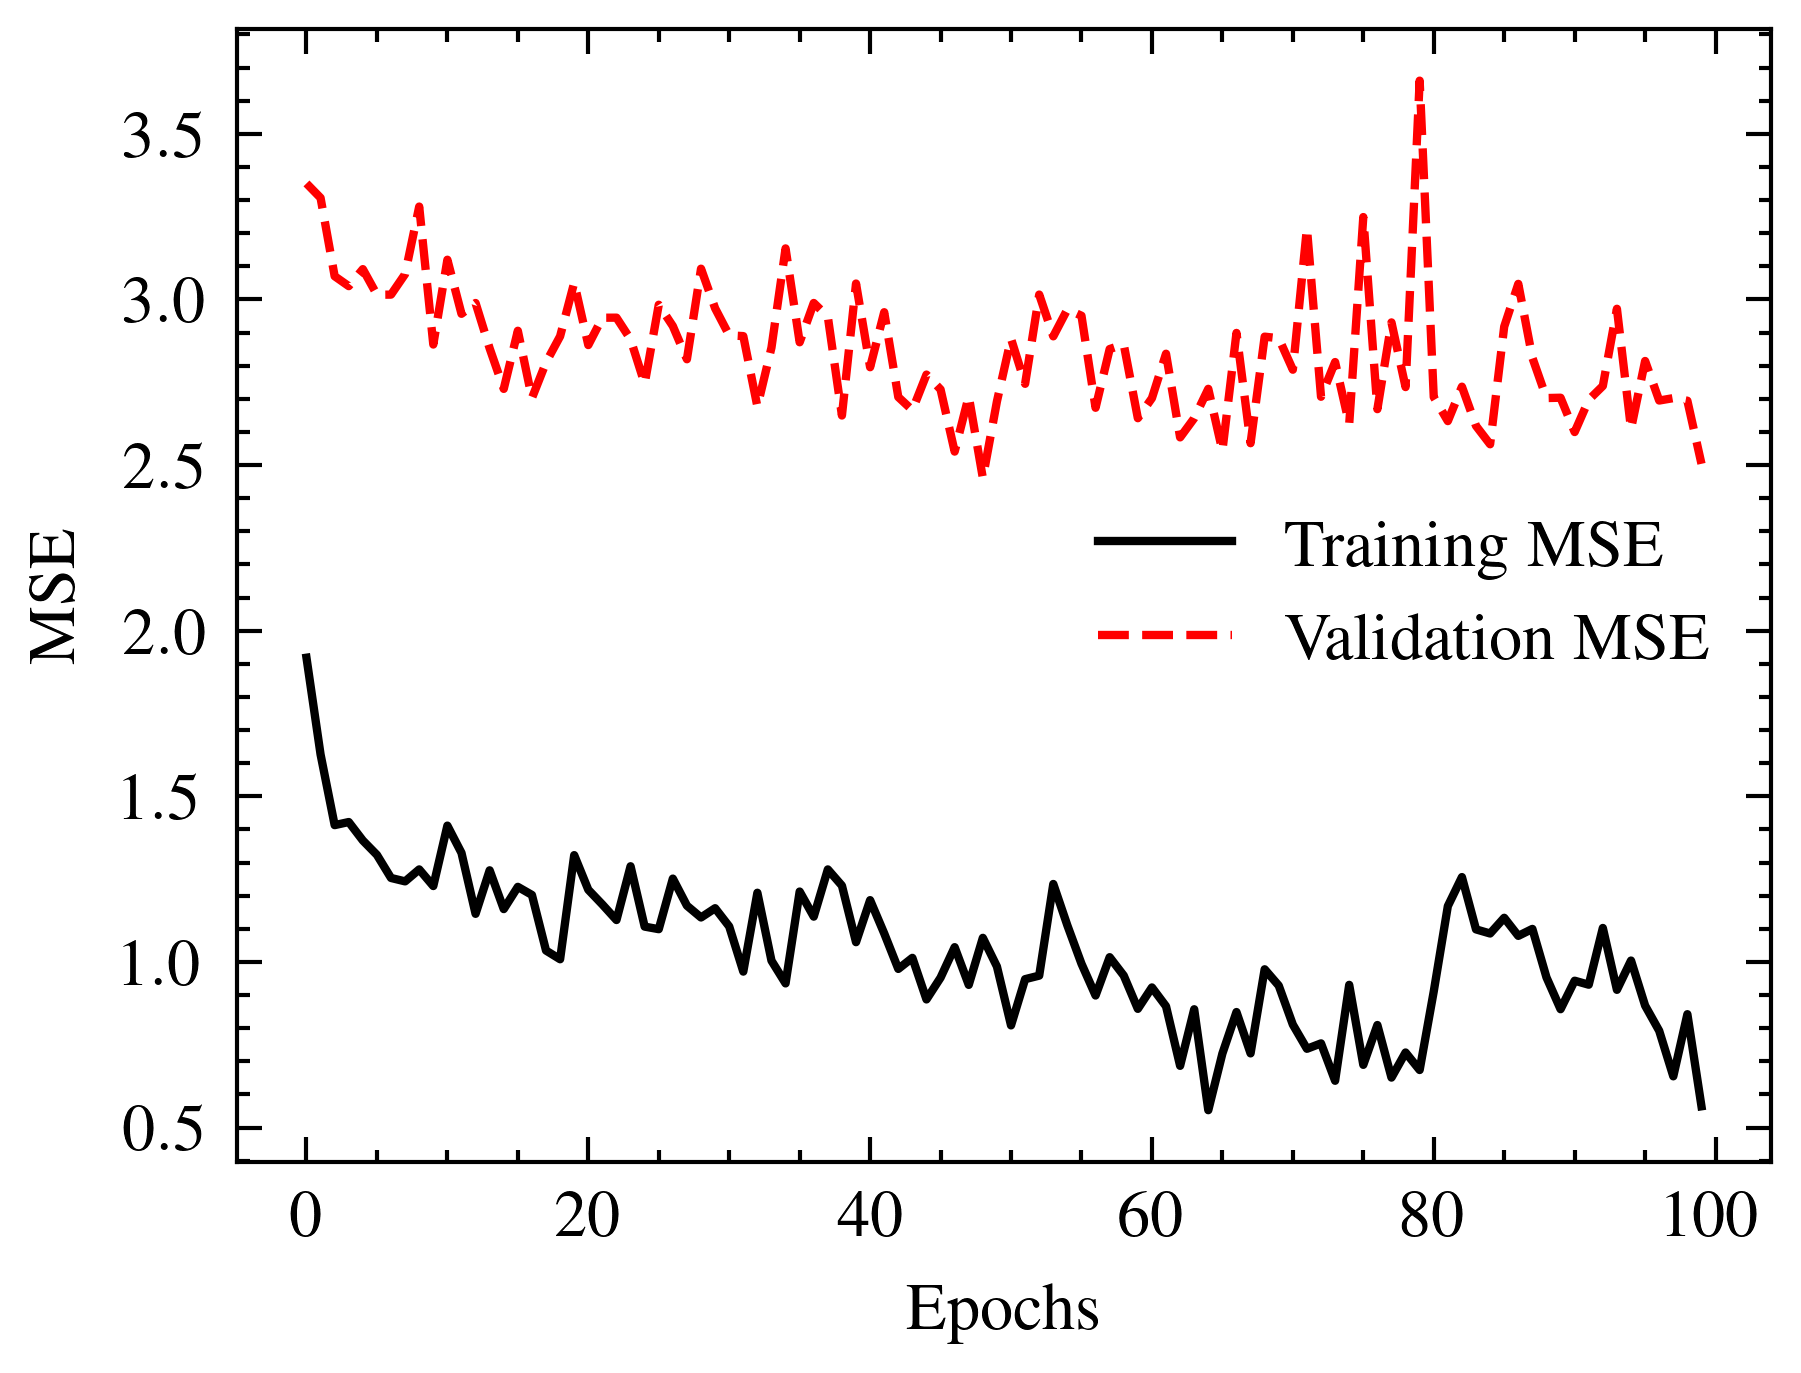

In [ ]:
# Set the training parameters
model_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mean_squared_error']) 


NUM_EPOCHS = 100
BATCH_SIZE = 5

# Train the model
history_lstm = model_lstm.fit(x=training_sentences, y=training_labels, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=(testing_sentences, testing_labels), 
                                    batch_size=BATCH_SIZE)
# Print the model summary
model_lstm.summary()

plt.plot(history_lstm.history['mean_squared_error'])
plt.plot(history_lstm.history['val_'+'mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel('MSE')
plt.legend(['Training MSE', 'Validation MSE'])
plt.show()

6/6 [==============================] - 4s 57ms/step


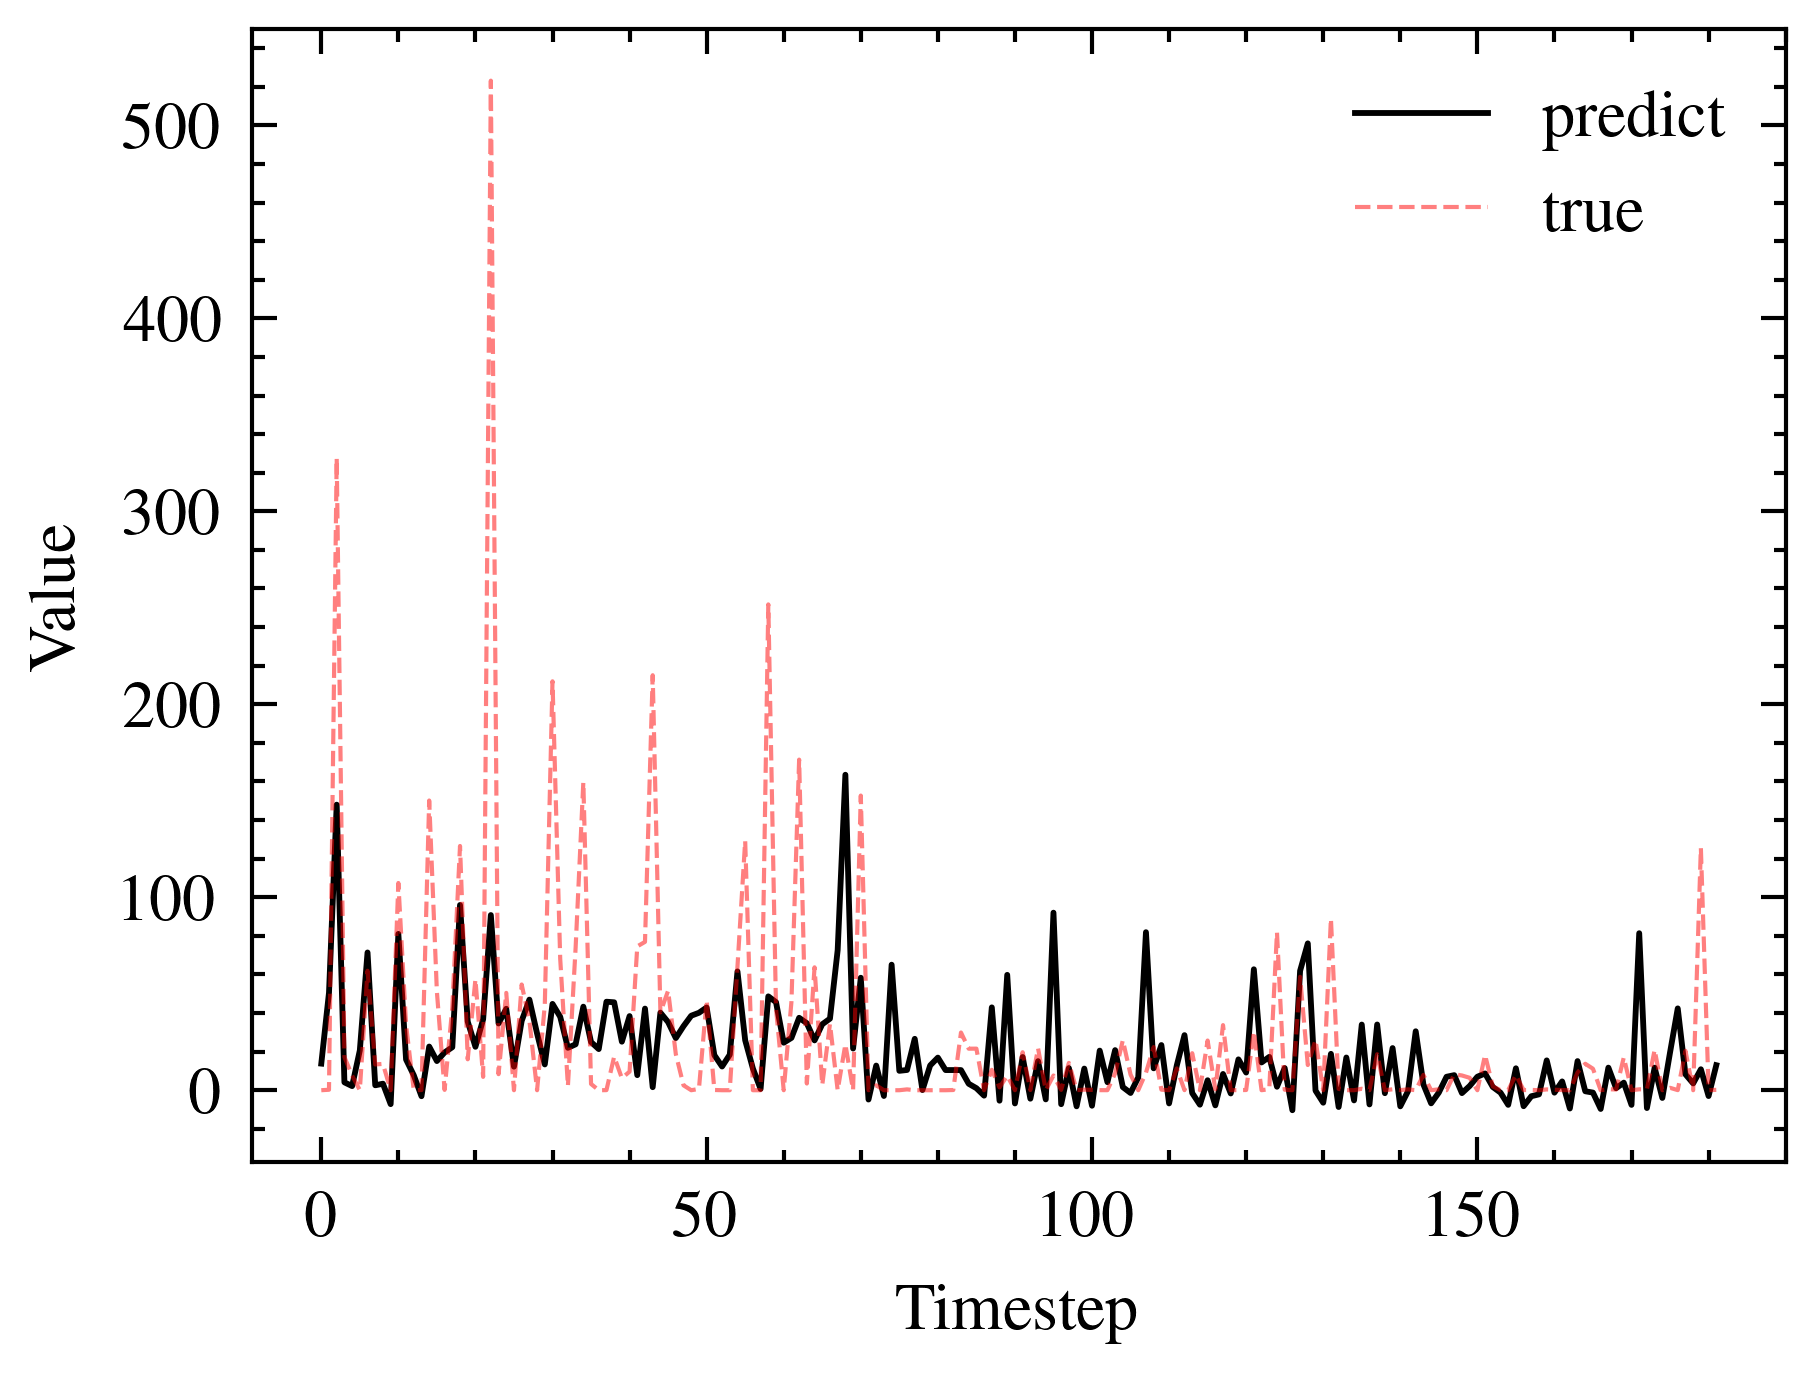

In [ ]:
predict = model_lstm.predict(testing_sentences)
predict = scaler.inverse_transform(predict)
plt.plot(predict, label="predict", linewidth=0.7, alpha=1.0)
testing_labels = scaler.inverse_transform(testing_labels)
plt.plot([i for i in range(testing_labels.shape[0])], testing_labels, linewidth=0.5, label="true", alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

### One week flow rate (results not promising so did 1000 epochs. test set consists of 6 timestamps only because 33 weeks, 0.2*33 = 6)

In [ ]:
def one_week_window(df_raw, scaler):
  df = df_raw.groupby(df_raw['week_count']).sum().reset_index()
  df = df.loc[:,["volume"]]
  df = scaler.fit_transform(df)
  df = tf.convert_to_tensor(df)

  print("1. Data has been read")
  print("2. Data being sliced into windows")

  window_len = 4
  stride = 1

  assert len(df) > window_len + 1

  new = []
  for i in range(window_len, len(df), stride):
    if i % 10000 == 0:
      print(i, "/", len(df))
    new.append([df[i-window_len:i], df[i]])

  df = new

  train_ratio = 0.8
  sequence_len = len(df)

  train_data = df[0:int(sequence_len*train_ratio)]
  test_data = df[int(sequence_len*train_ratio):]

  print("3. Completed")

  return train_data, test_data, scaler

In [ ]:
df_raw = read_data(n=None)

In [ ]:
scaler = StandardScaler() 
train_data, test_data, scaler = one_week_window(df_raw, scaler)

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


# Loop over all training examples 
for datax, datay in zip(train_data, test_data):
  training_sentences.append(np.array(datax[0]))
  training_labels.append(datax[1])
  testing_sentences.append(np.array(datay[0]))
  testing_labels.append(datay[1])

# Convert labels lists to numpy array
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)
testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

1. Data has been read
2. Data being sliced into windows
3. Completed


In [ ]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, input_shape=(training_sentences.shape[1], training_sentences.shape[2]), activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(40, activation='linear'),
    tf.keras.layers.Dense(30, activation='linear'),
    tf.keras.layers.Dense(20, activation='linear'),
    tf.keras.layers.Dense(10, activation='linear'),
    tf.keras.layers.Dense(1, activation='linear')
])

Epoch 1/50
6/6 [==============================] - 25s 845ms/step - loss: 0.5196 - mean_squared_error: 0.5196 - val_loss: 2.6463 - val_mean_squared_error: 2.6463
Epoch 2/50
6/6 [==============================] - 0s 62ms/step - loss: 0.3521 - mean_squared_error: 0.3521 - val_loss: 2.7521 - val_mean_squared_error: 2.7521
Epoch 3/50
6/6 [==============================] - 0s 54ms/step - loss: 0.2521 - mean_squared_error: 0.2521 - val_loss: 2.7894 - val_mean_squared_error: 2.7894
Epoch 4/50
6/6 [==============================] - 0s 55ms/step - loss: 0.1321 - mean_squared_error: 0.1321 - val_loss: 2.8809 - val_mean_squared_error: 2.8809
Epoch 5/50
6/6 [==============================] - 0s 57ms/step - loss: 0.1796 - mean_squared_error: 0.1796 - val_loss: 2.9278 - val_mean_squared_error: 2.9278
Epoch 6/50
6/6 [==============================] - 0s 54ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 2.9600 - val_mean_squared_error: 2.9600
Epoch 7/50
6/6 [============================

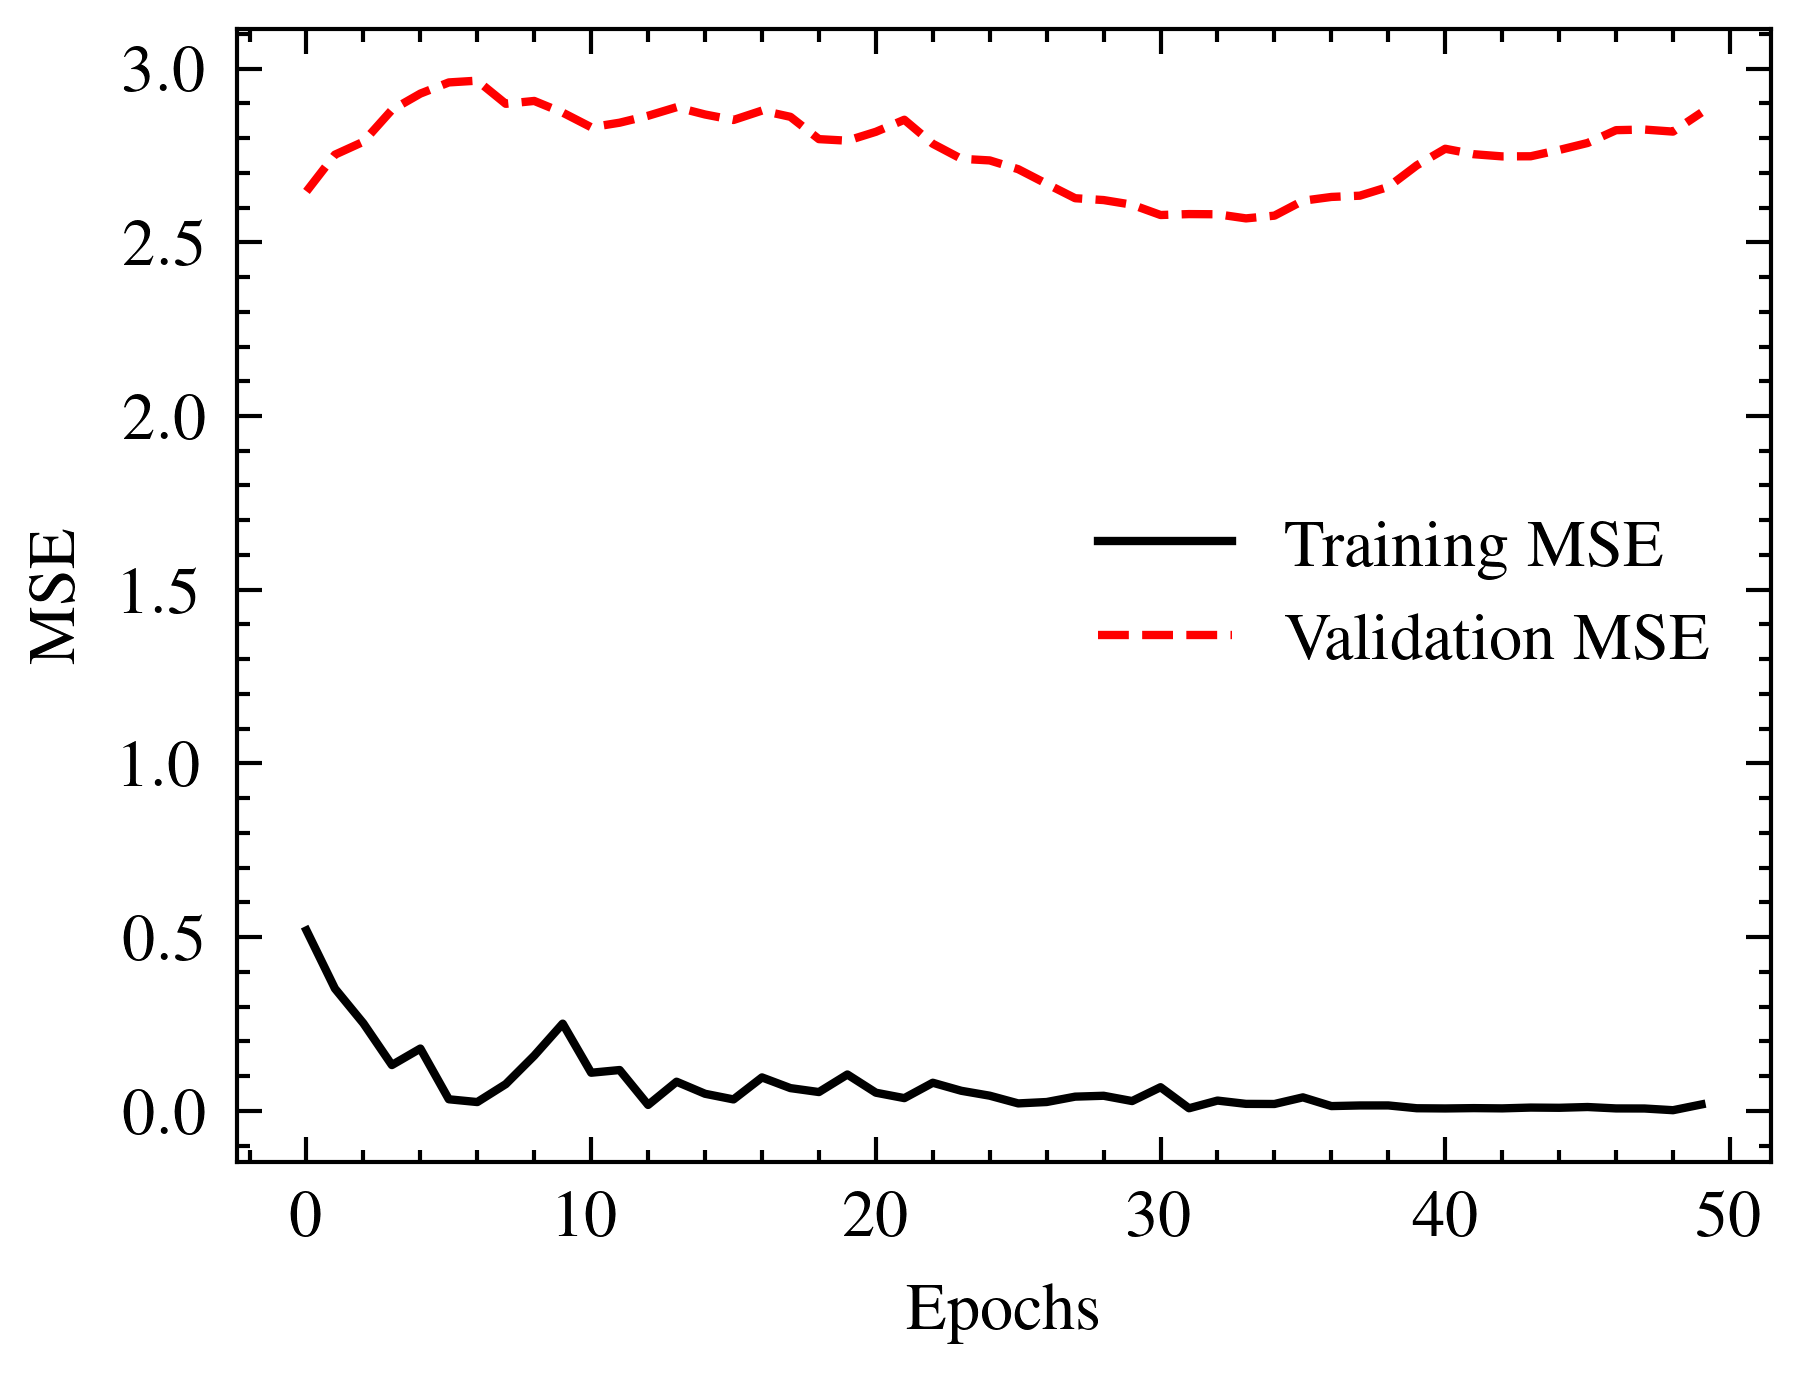

In [ ]:
# Set the training parameters
model_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mean_squared_error']) 


NUM_EPOCHS = 50
BATCH_SIZE = 1

# Train the model
history_lstm = model_lstm.fit(x=training_sentences, y=training_labels, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=(testing_sentences, testing_labels), 
                                    batch_size=BATCH_SIZE)
# Print the model summary
model_lstm.summary()

plt.plot(history_lstm.history['mean_squared_error'])
plt.plot(history_lstm.history['val_'+'mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel('MSE')
plt.legend(['Training MSE', 'Validation MSE'])
plt.show()

1/1 [==============================] - 8s 8s/step


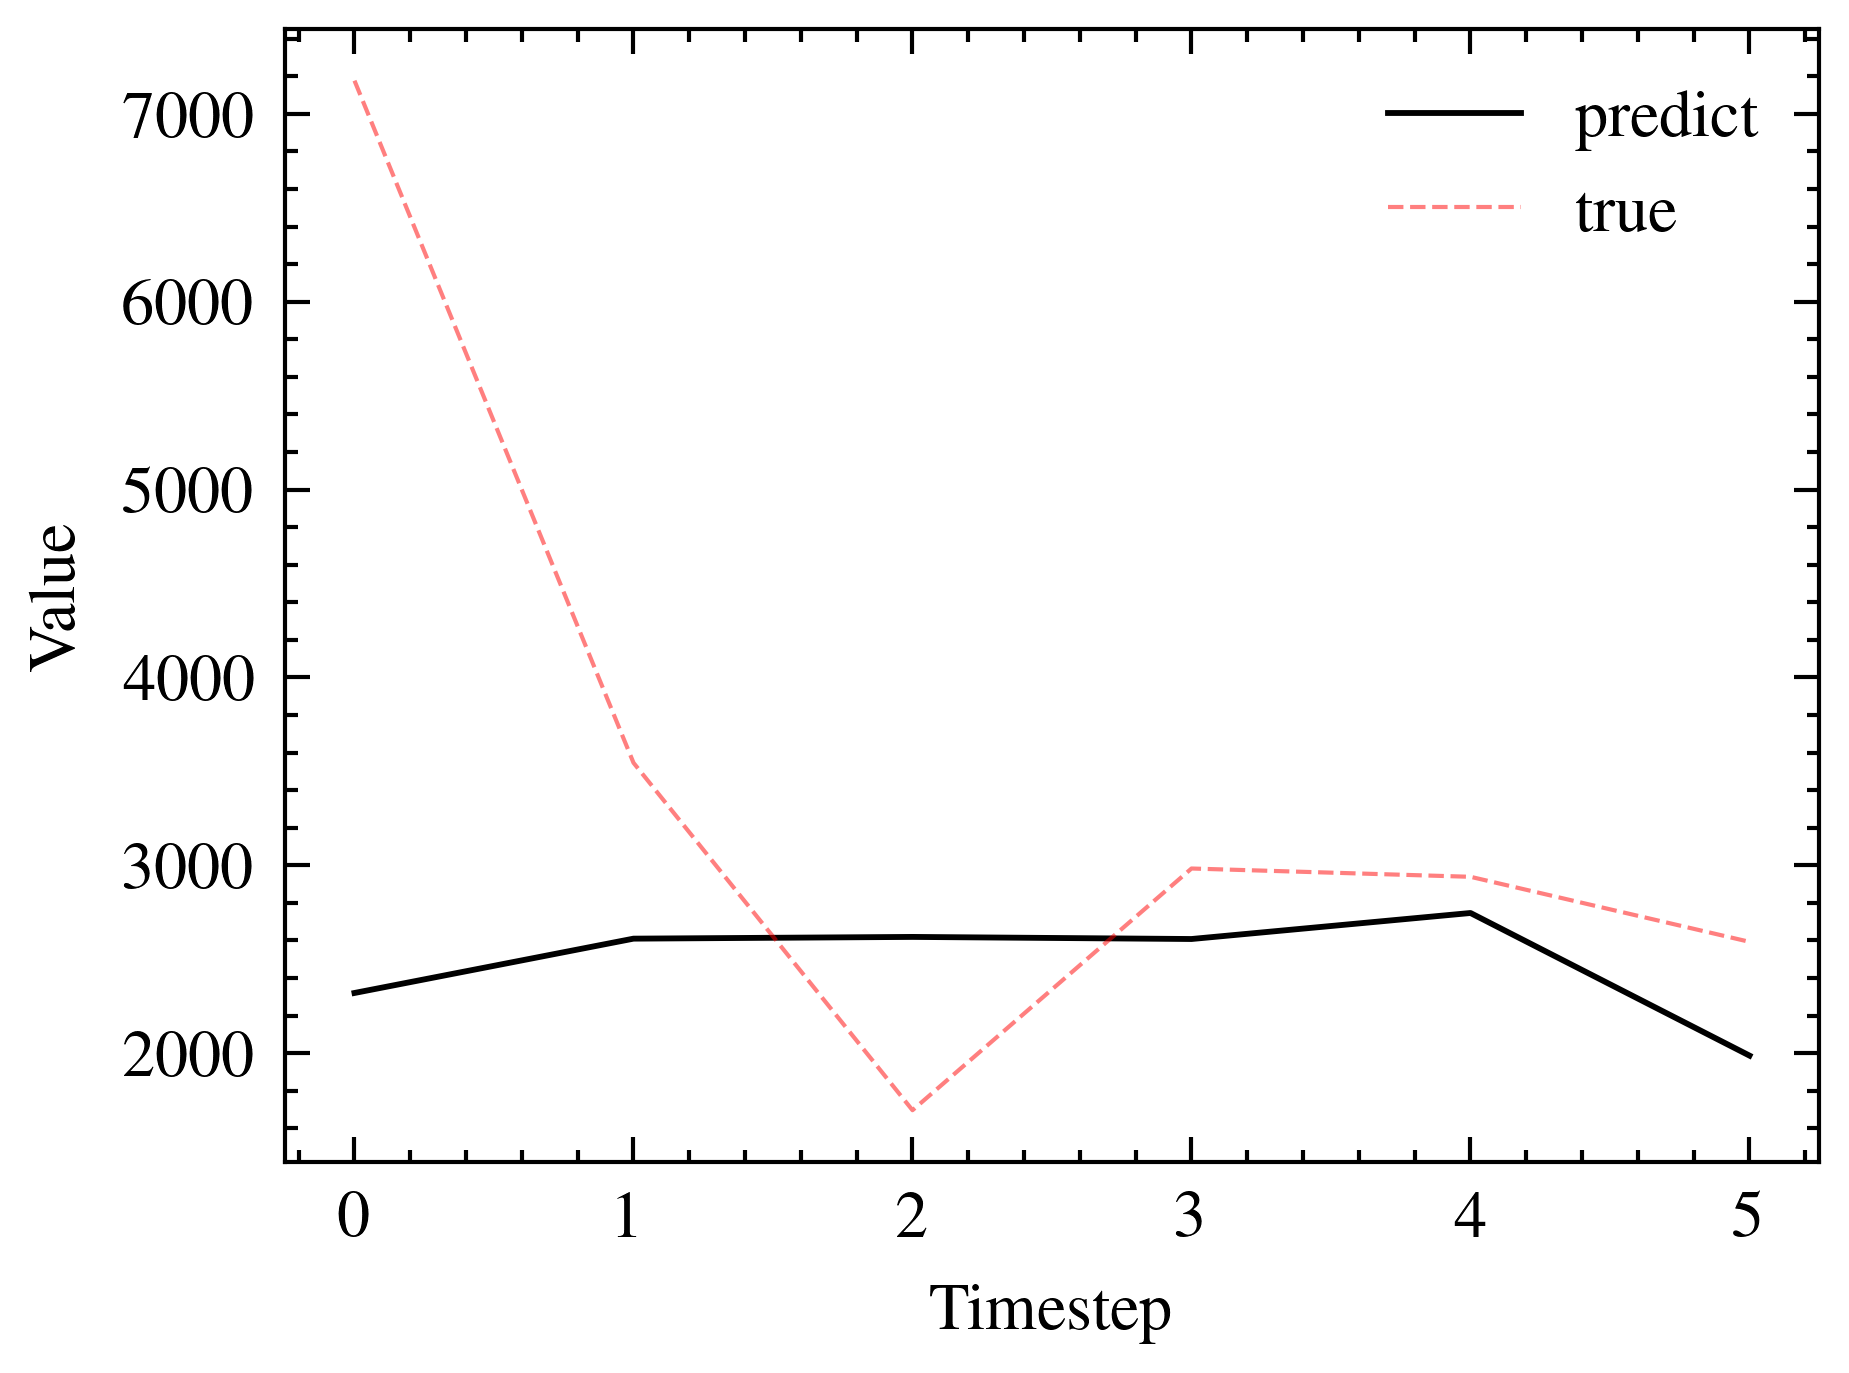

In [ ]:
predict = model_lstm.predict(testing_sentences)
predict = scaler.inverse_transform(predict)
plt.plot(predict, label="predict", linewidth=0.7, alpha=1.0)
testing_labels = scaler.inverse_transform(testing_labels)
plt.plot([i for i in range(testing_labels.shape[0])], testing_labels, linewidth=0.5, label="true", alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()